In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


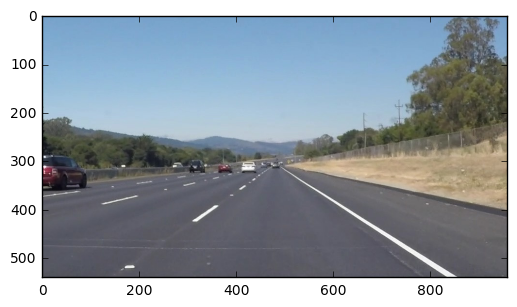

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

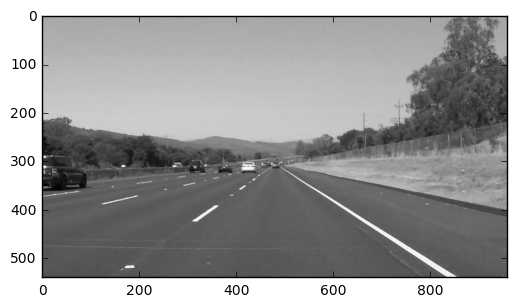

In [4]:
gray_img = grayscale(image)
plt.imshow(gray_img, cmap='gray')

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

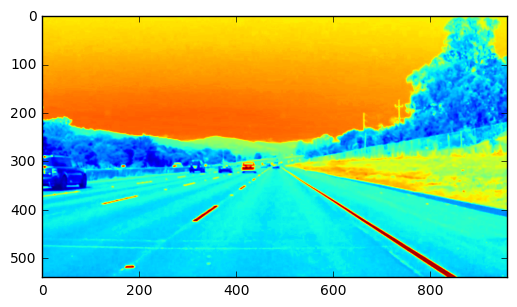

In [6]:
blur_img = gaussian_blur(gray_img, 5)
plt.imshow(blur_img)

In [7]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

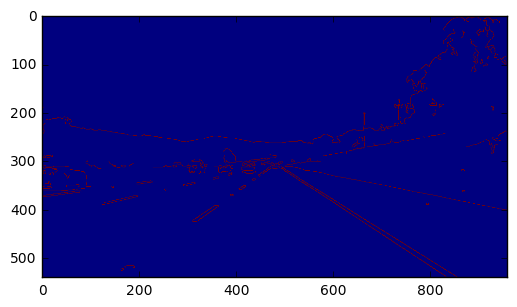

In [8]:
canny_img = canny(blur_img, 50, 150)
plt.imshow(canny_img)

In [9]:
def dilated(img, kernel, iterations):
    """Applies the dilate transform"""
    return cv2.dilate(img,kernel,iterations)



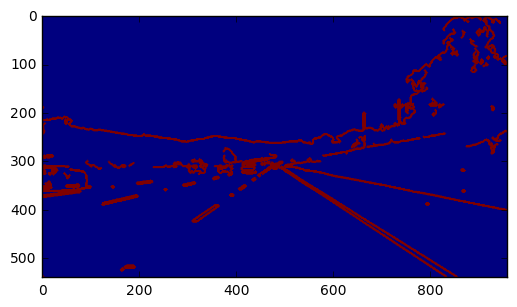

In [10]:
dilated_img = dilated(canny_img, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)), 1)
plt.imshow(dilated_img)

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

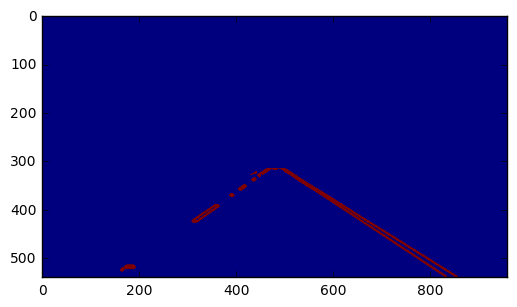

In [12]:
bottom_left = [100, 540]
bottom_right = [900, 540]
top_right = [500, 315]
top_left = [450, 315]

v = [np.array([bottom_left, bottom_right, top_right, top_left], dtype=np.int32)]

masked_img = region_of_interest(dilated_img, v)
plt.imshow(masked_img)

In [13]:
def draw_lines(img, all_lines, color=[255, 0, 0], thickness=10):
    
    r_slope=[]
    l_slope=[]
    left_lane = []
    right_lane = []
    y_min = image.shape[0]
    y_max = image.shape[0]
    
   
    for line in all_lines:
        for x1,y1,x2,y2 in line:
            
            slope = (y2-y1)/(x2-x1)
            
            if slope <= -0.3:
                l_slope.append(slope)
                left_lane.append(line)                
            elif slope >= 0.3 and slope <= 0.7:
                r_slope.append(slope)
                right_lane.append(line)
               
            if y1 < y_min:
                y_min = y1
            elif y2< y_min:
                y_min = y2
                
          
            
    l_slope_mean = np.mean(l_slope)
    r_slope_mean = np.mean(r_slope)
      
    l_xy_av = np.array(left_lane)
    l_mean = np.mean(l_xy_av,axis=0)
    
    r_xy_av = np.array(right_lane)
    r_mean = np.mean(r_xy_av,axis=0)
   
    l_y_intercept = l_mean[0][1] - (l_mean[0][0] * l_slope_mean)
    r_y_intercept = r_mean[0][1] - (r_mean[0][0] * r_slope_mean)
    
    #find associated x1 for y_global_min using (y_global_min = m_avg * x1 + b)
    #similarly find associated x2 for y_max = imshape[0] (this is the lowest y in the image)

    x_l_1 = int((y_min - l_y_intercept)/l_slope_mean) 
    x_l_2 = int((y_max - l_y_intercept)/l_slope_mean)
    x_r_1 = int((y_min - r_y_intercept)/r_slope_mean)
    x_r_2 = int((y_max - r_y_intercept)/r_slope_mean)
    
    cv2.line(img, (x_l_1, y_min), (x_l_2, y_max), color, thickness)
    cv2.line(img, (x_r_1, y_min), (x_r_2, y_max), color, thickness)

In [14]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    hgh_lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, hgh_lines)
    return line_img

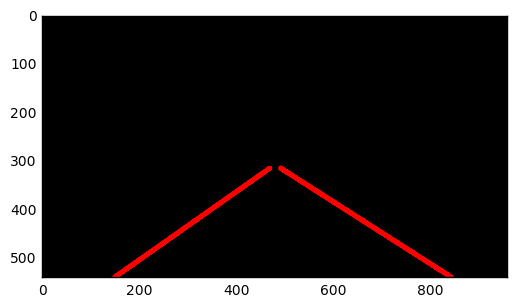

In [15]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 0.8 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 50    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
hough_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(hough_img)

In [16]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

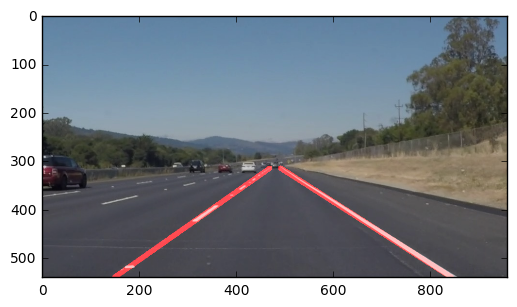

In [17]:
final_img = weighted_img(hough_img, image, α=0.8, β=1., λ=0.)
plt.imshow(final_img)

In [18]:
def pipeline(image):  
    
    
    bottom_left = [100, 540]
    bottom_right = [900, 540]
    top_right = [500, 315]
    top_left = [450, 315]

    v = [np.array([bottom_left, bottom_right, top_right, top_left], dtype=np.int32)]

    
    
    ### Run canny edge detection and mask region of interest
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, 5)
    canny_img = canny(blur_img, 50, 150)
    dilated_img = dilated(canny_img, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)), 1)    
    masked_img = region_of_interest(dilated_img, v)
    


    ### Run Hough Lines and separate by +/- slope
    
    rho = 0.8 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    #hough_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    hgh_lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    
      
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, hgh_lines, thickness=8)
    
    line_img = region_of_interest(line_img, v)
    final_img = weighted_img(line_img, image)
    

    return final_img

In [19]:
def process_image(image):
    result = pipeline(image)
    return result

In [20]:

import os

path = ("test_images/")
image_list = os.listdir("test_images/")

 
for file in image_list:
    print(path+file)
    img = mpimg.imread(path+file)
    result_image = process_image(img)    
    cv2.imwrite(path + file + "_Copy.jpg", result_image)

test_images/solidWhiteCurve.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowLeft.jpg
test_images/whiteCarLaneSwitch.jpg


In [21]:
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML



white_output = 'final.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


100%|███████████████████████████████████████████████████████████▋| 221/222 [00:10<00:00, 21.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 

Wall time: 11.2 s


References:

https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013  
http://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html  
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html  
http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html  
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html  
https://carnd-udacity.atlassian.net/wiki/questions  
